In [1]:
using Colors
using CSV
using DataFrames
using Graphs
using Plots
using Random: MersenneTwister
using StatsBase: mean, std, countmap
using Statistics

include("../src/ColorScheme.jl")
using .ColorScheme: DARK_RED, LIGHT_RED, GRAY, LIGHT_BLUE, DARK_BLUE, COLOR_GRAD

include("../src/Network.jl")
using .Network: create_weighted_cycle_graph, create_cycle_graph, desc, plot_degree_distribution, mat_nv, mat_ne, mat_degree, mat_update_weight!, plot_graph, average_distance

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, Strategy, C, D

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
default(
    fontfamily="Arial",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    dpi=600,
    lw=2.0,
    marker=:circle,
    markerstrokewidth=0,
);

In [3]:
FILE_NAMES = [
    "../output/CircleModel_20240826_144719.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_182404.csv",  # σR ∈ 0:49, 10 trials
    "../output/CircleModel_20240826_200917.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240828_113854.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240828_191857.csv",  # β ∈ 0.0:0.1:0.9, sigmaθ ∈ {0.01, 0.1, 0.2, 0.3}, 10 trials
    "../output/CircleModel_20240827_170414.csv",  # combination, 10 trials
    "../output/CircleModel_20240827_181750.csv",  # combination, 10 trials
    # "../output/CircleModel_20240827_100534.csv",  # all, 10 trials
    "../output/CircleModel_20240827_215238.csv",  # all, 10 trials
    "../output/CircleModel_20240828_213318.csv",  # all, 10 trials
    "../output/CircleModel_20240829_093929.csv",  # all, 10 trials
    "../output/CircleModel_20240829_154557.csv",  # all, 10 trials
    "../output/CircleModel_20240829_210419.csv",  # all, 10 trials
];

In [4]:
dfs = [DataFrame(CSV.File(n)) for n in FILE_NAMES]
df = vcat(dfs...);

In [5]:
b_vec = [1.6, 1.7, 1.8, 1.9, 2.0]
peak_node_variability_vec = [0, 1, 2, 4, 8, 16]
resource_limit_β_vec = [0.1, 0.3, 0.5, 0.7, 0.9]
resource_limit_σ_vec = [0.1, 0.2]

combination_var_df = df[
    df.C_rate₀ .== 0.0 .&&
    df.relationship_increment_factor .== 1.0 .&&
    ([x in b_vec for x in df.b]) .&&
    ([x in peak_node_variability_vec for x in df.peak_node_variability]) .&&
    ([x in resource_limit_β_vec for x in df.resource_limit_β]) .&&
    ([x in resource_limit_σ_vec for x in df.resource_limit_σ]), :]

groupby_combine_sort(df::DataFrame, keys::Vector)::DataFrame = sort(combine(groupby(df, keys), :cooperation_rate => mean => :cooperation_rate))

combination_var_df = groupby_combine_sort(combination_var_df, [:b, :peak_node_variability, :resource_limit_β, :resource_limit_σ])

Row,b,peak_node_variability,resource_limit_β,resource_limit_σ,cooperation_rate
,Float64,Int64,Float64,Float64,Float64
1,1.6,0,0.1,0.1,0.0457495
2,1.6,0,0.1,0.2,0.205569
3,1.6,0,0.3,0.1,0.0499207
4,1.6,0,0.3,0.2,0.230715
5,1.6,0,0.5,0.1,0.0680627
6,1.6,0,0.5,0.2,0.24158
7,1.6,0,0.7,0.1,0.166419
8,1.6,0,0.7,0.2,0.252012
9,1.6,0,0.9,0.1,0.286607


In [6]:
function line_color(β::Float64)::String
    return if β == 0.9
        "#B32034"
    elseif β == 0.5
        "#2D579A"
    else
        "#000000"
    end
end

function line_marker(β::Float64)::Symbol
    return if β == 0.9
        :circle
    elseif β == 0.5
        :utriangle
    else
        :x
    end
end

function line_color(σR::Int)::String
    return if σR == 16
        "#B32034"
    elseif σR == 4
        "#2D579A"
    else
        "#000000"
    end
end

function line_marker(σR::Int)::Symbol
    return if σR == 16
        :circle
    elseif σR == 4
        :utriangle
    else
        :x
    end
end;

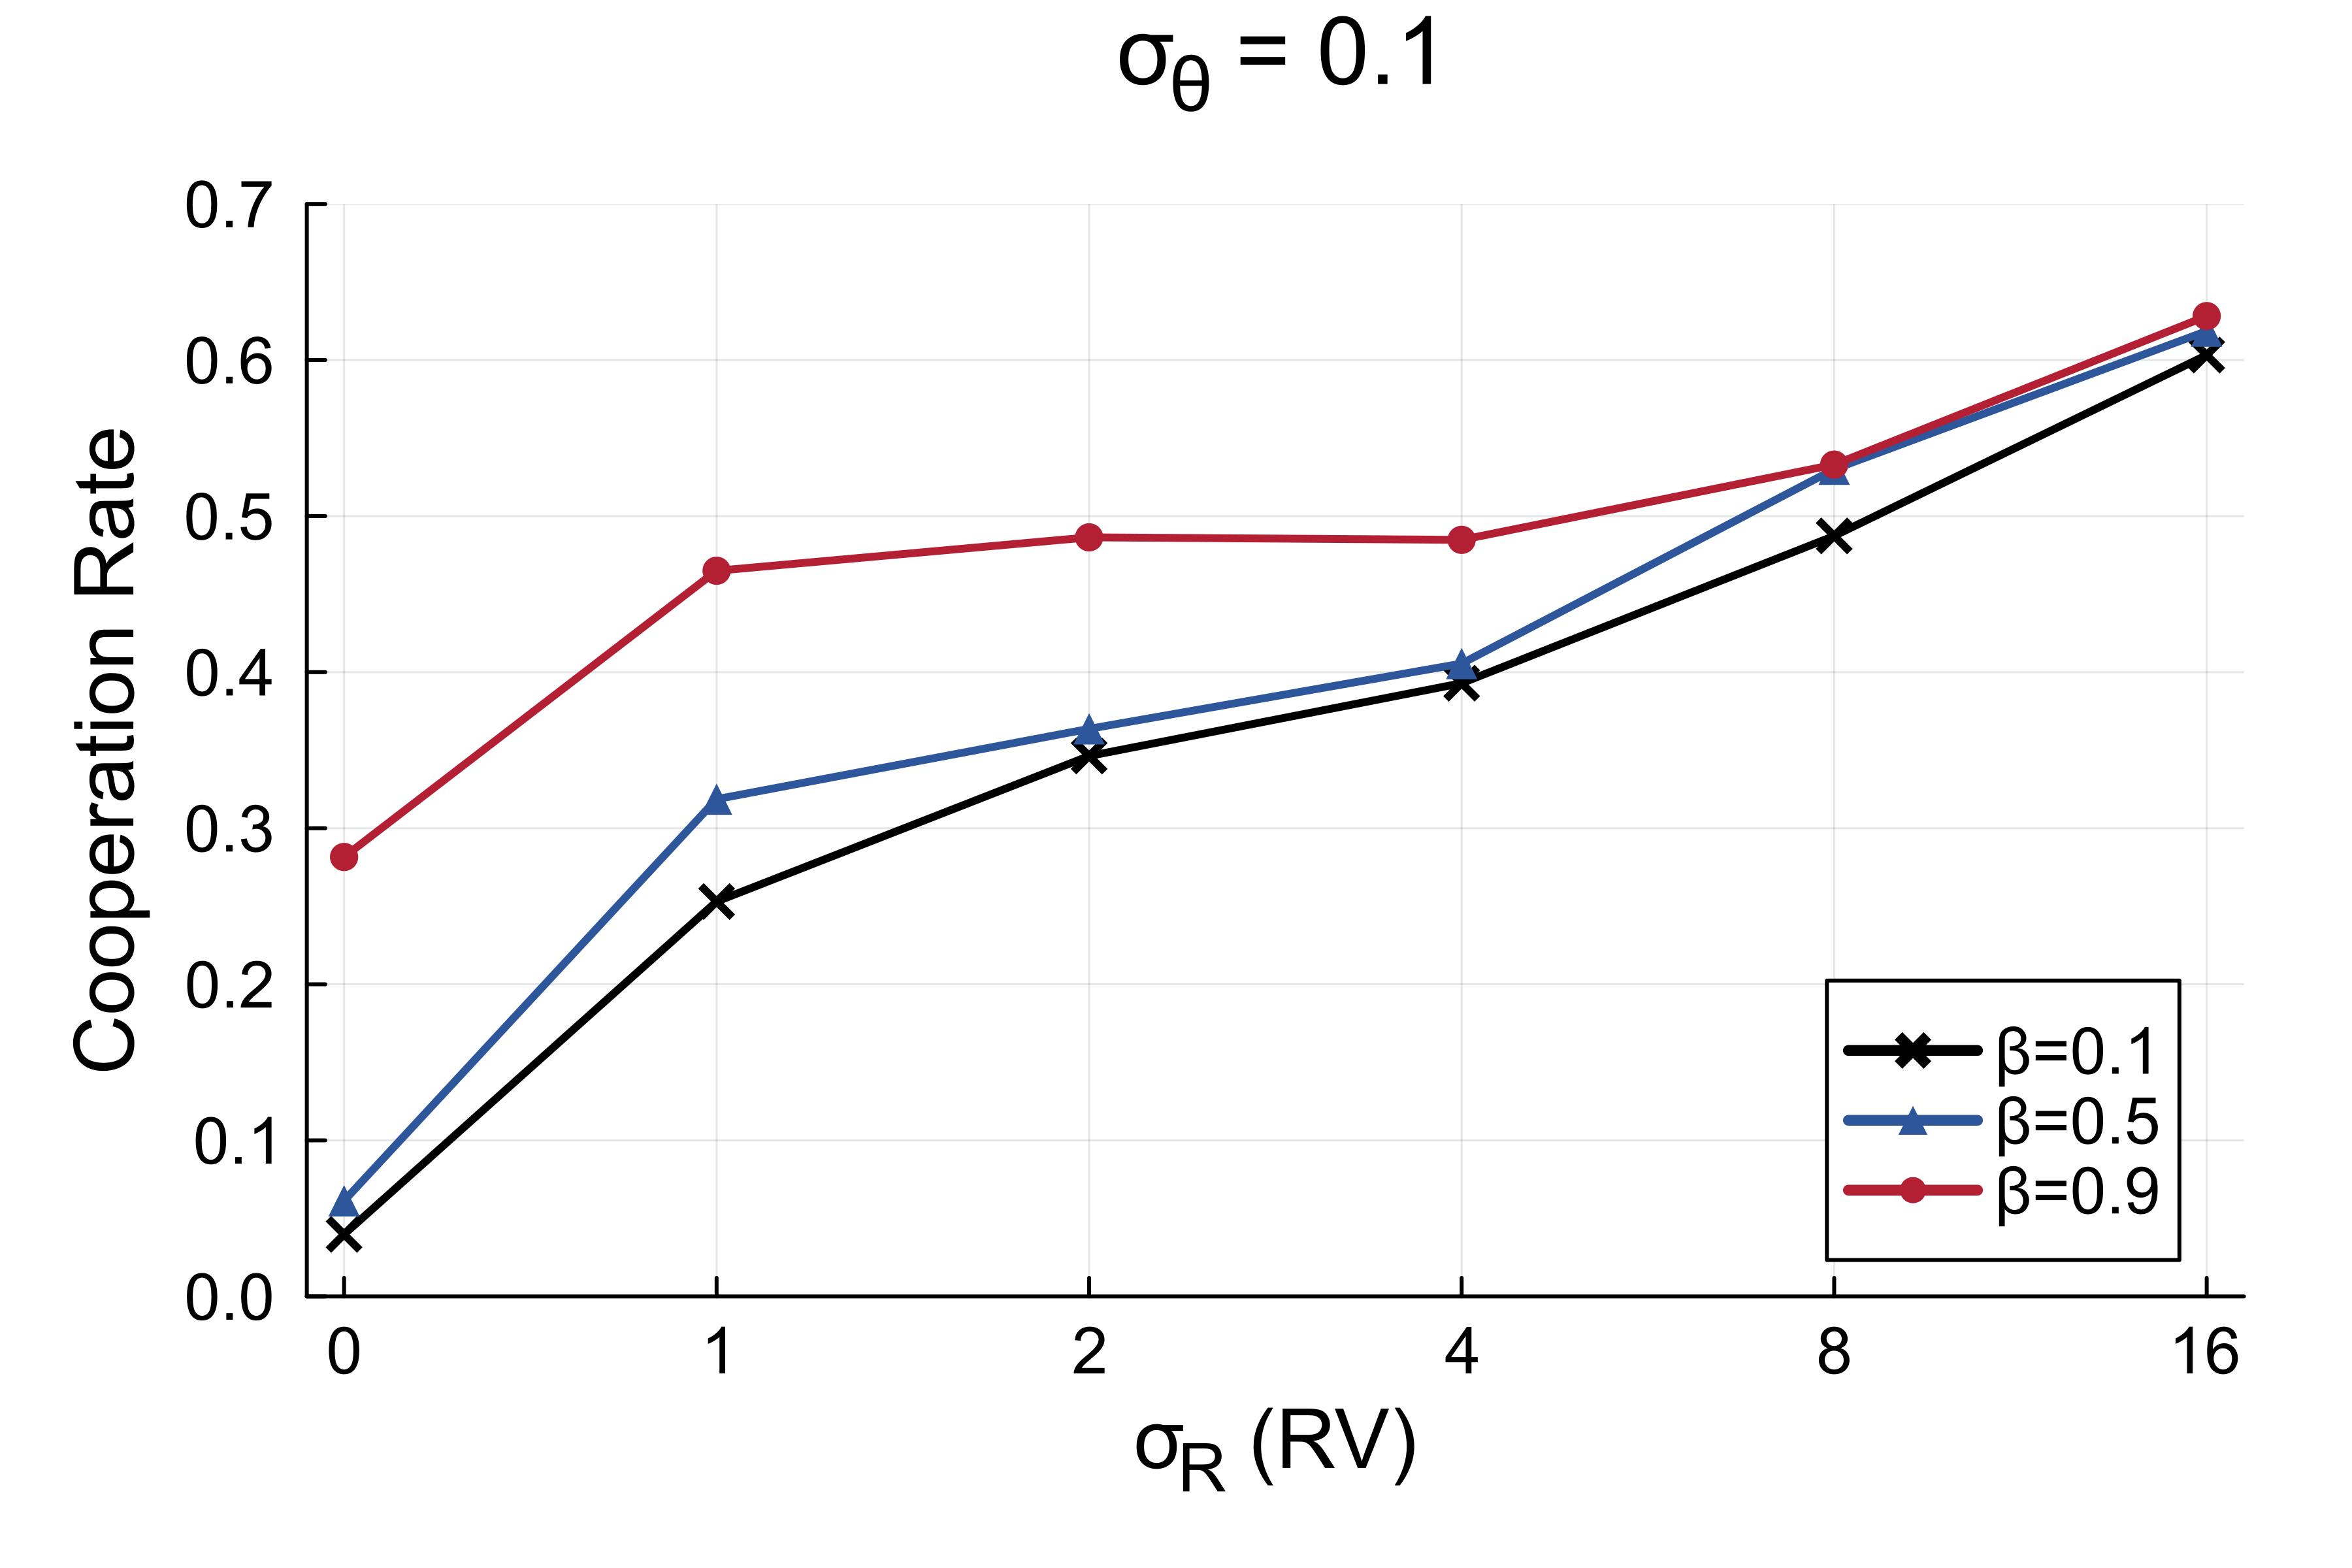

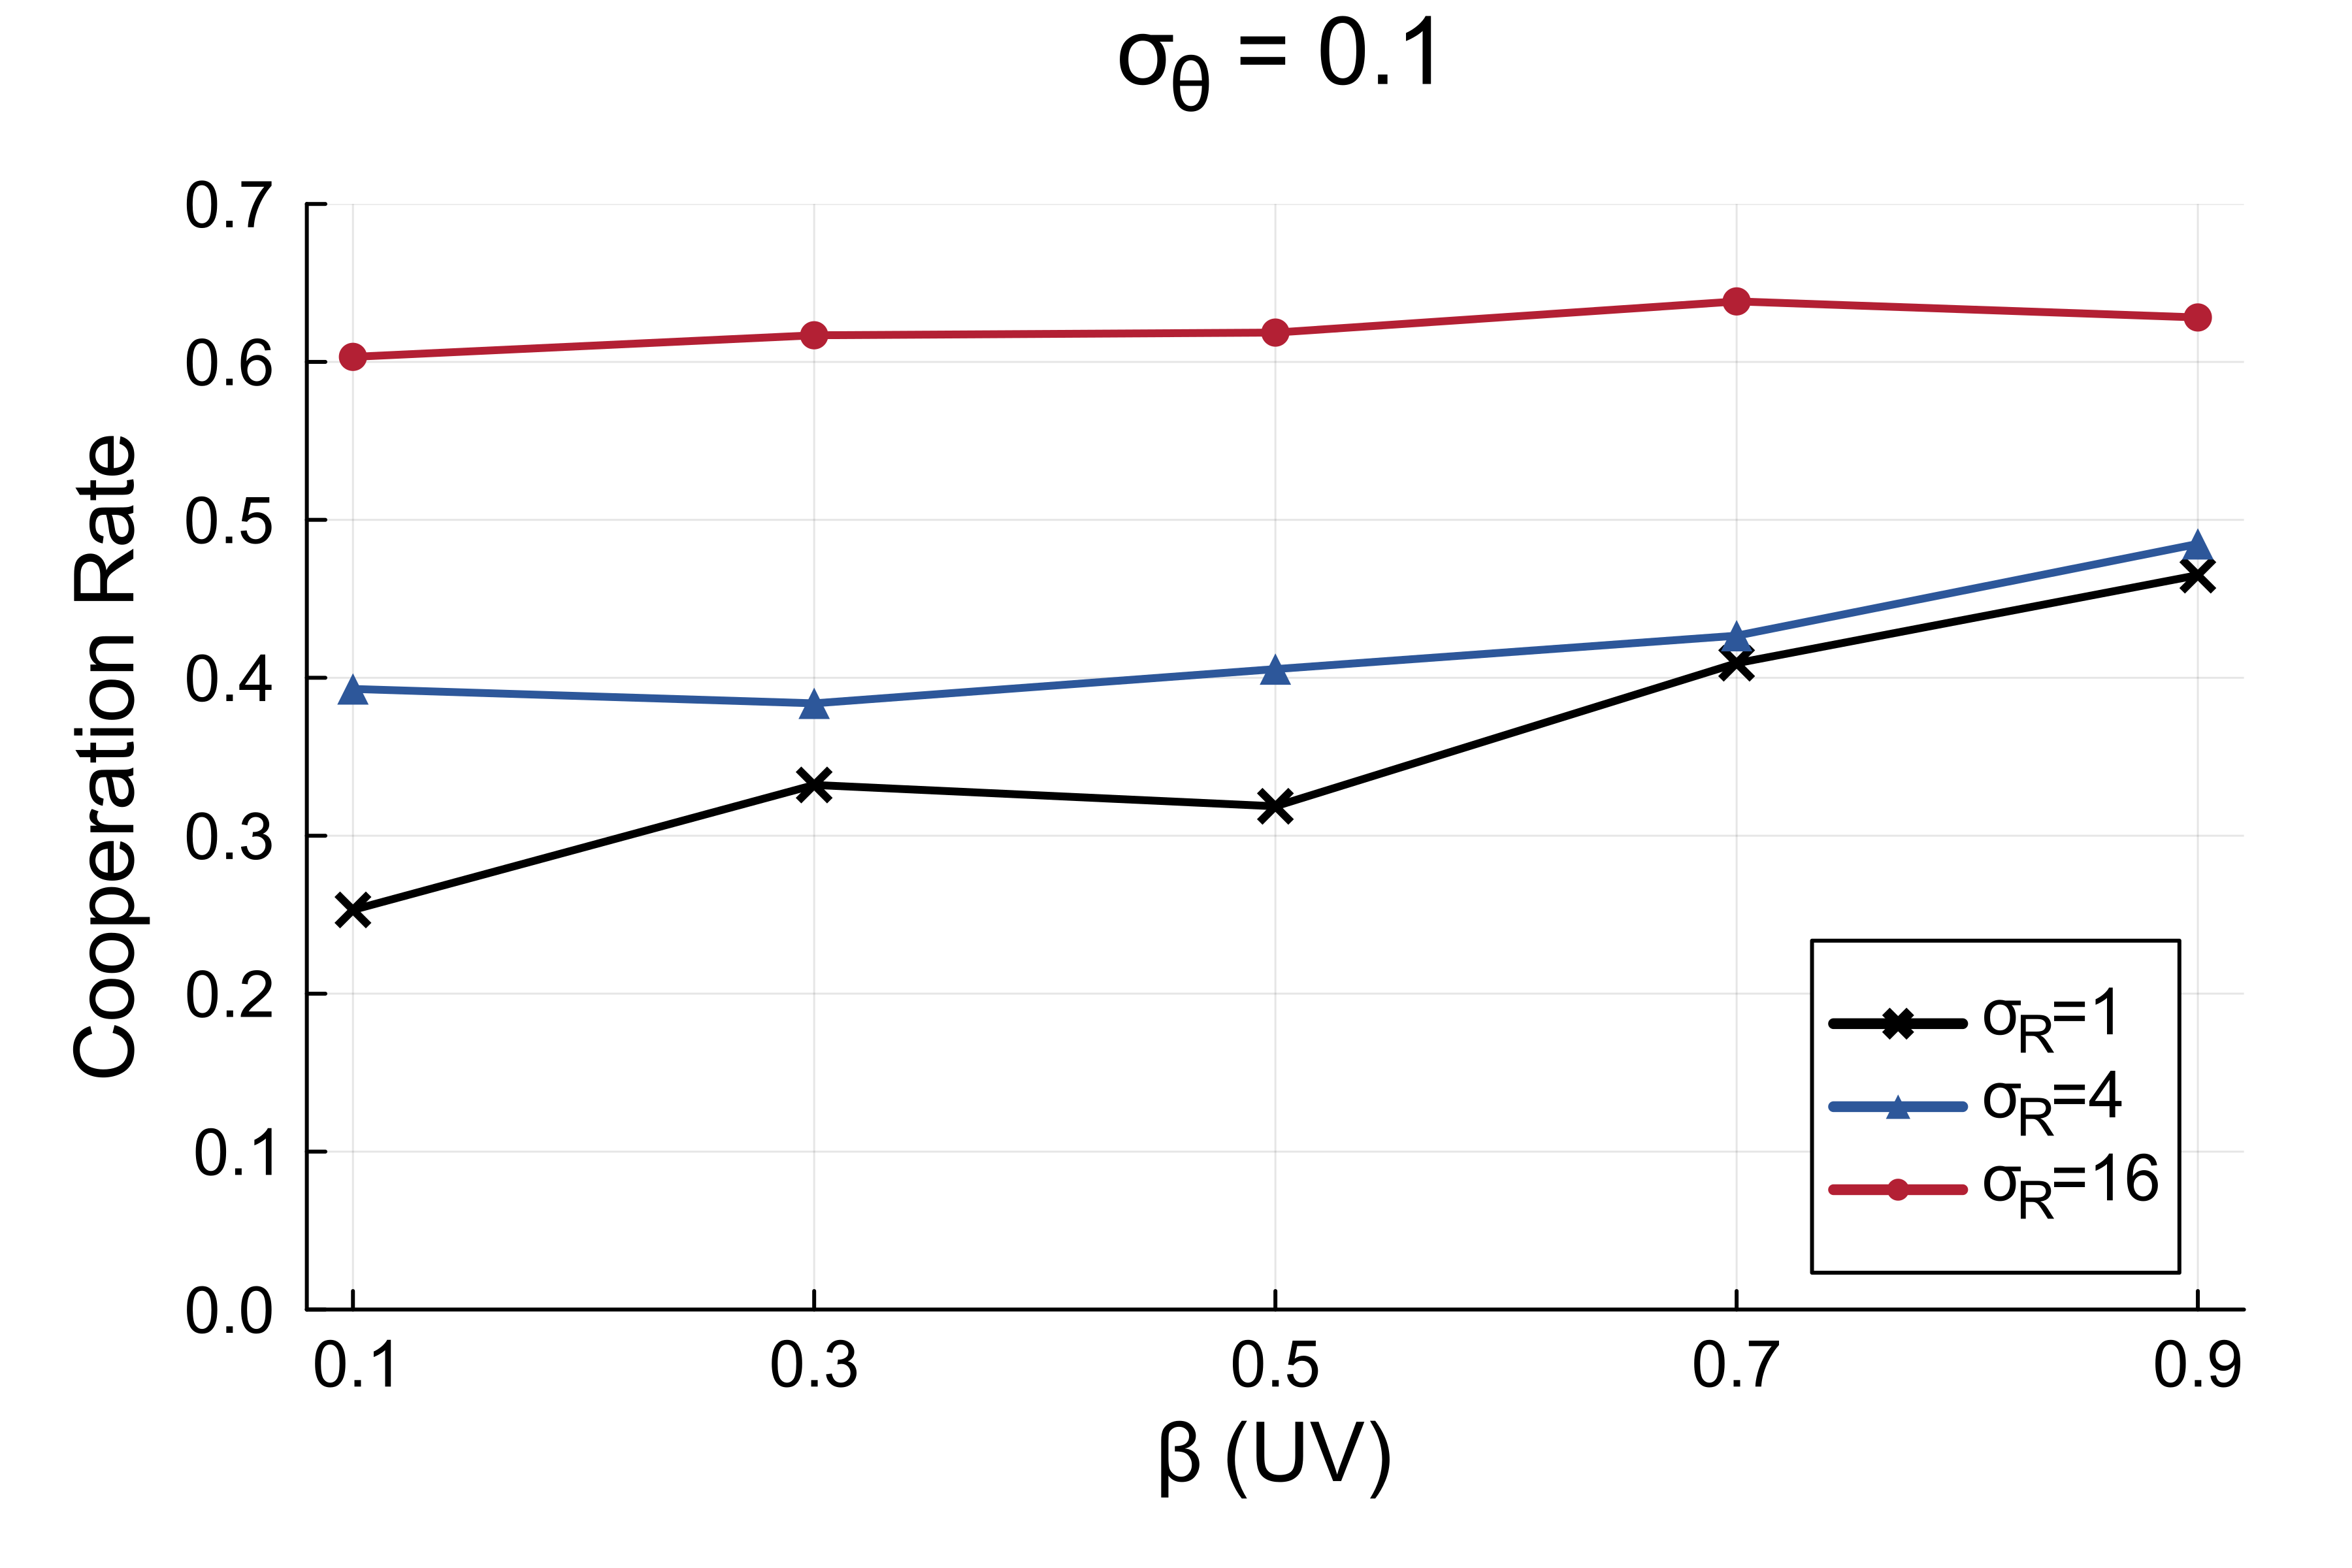

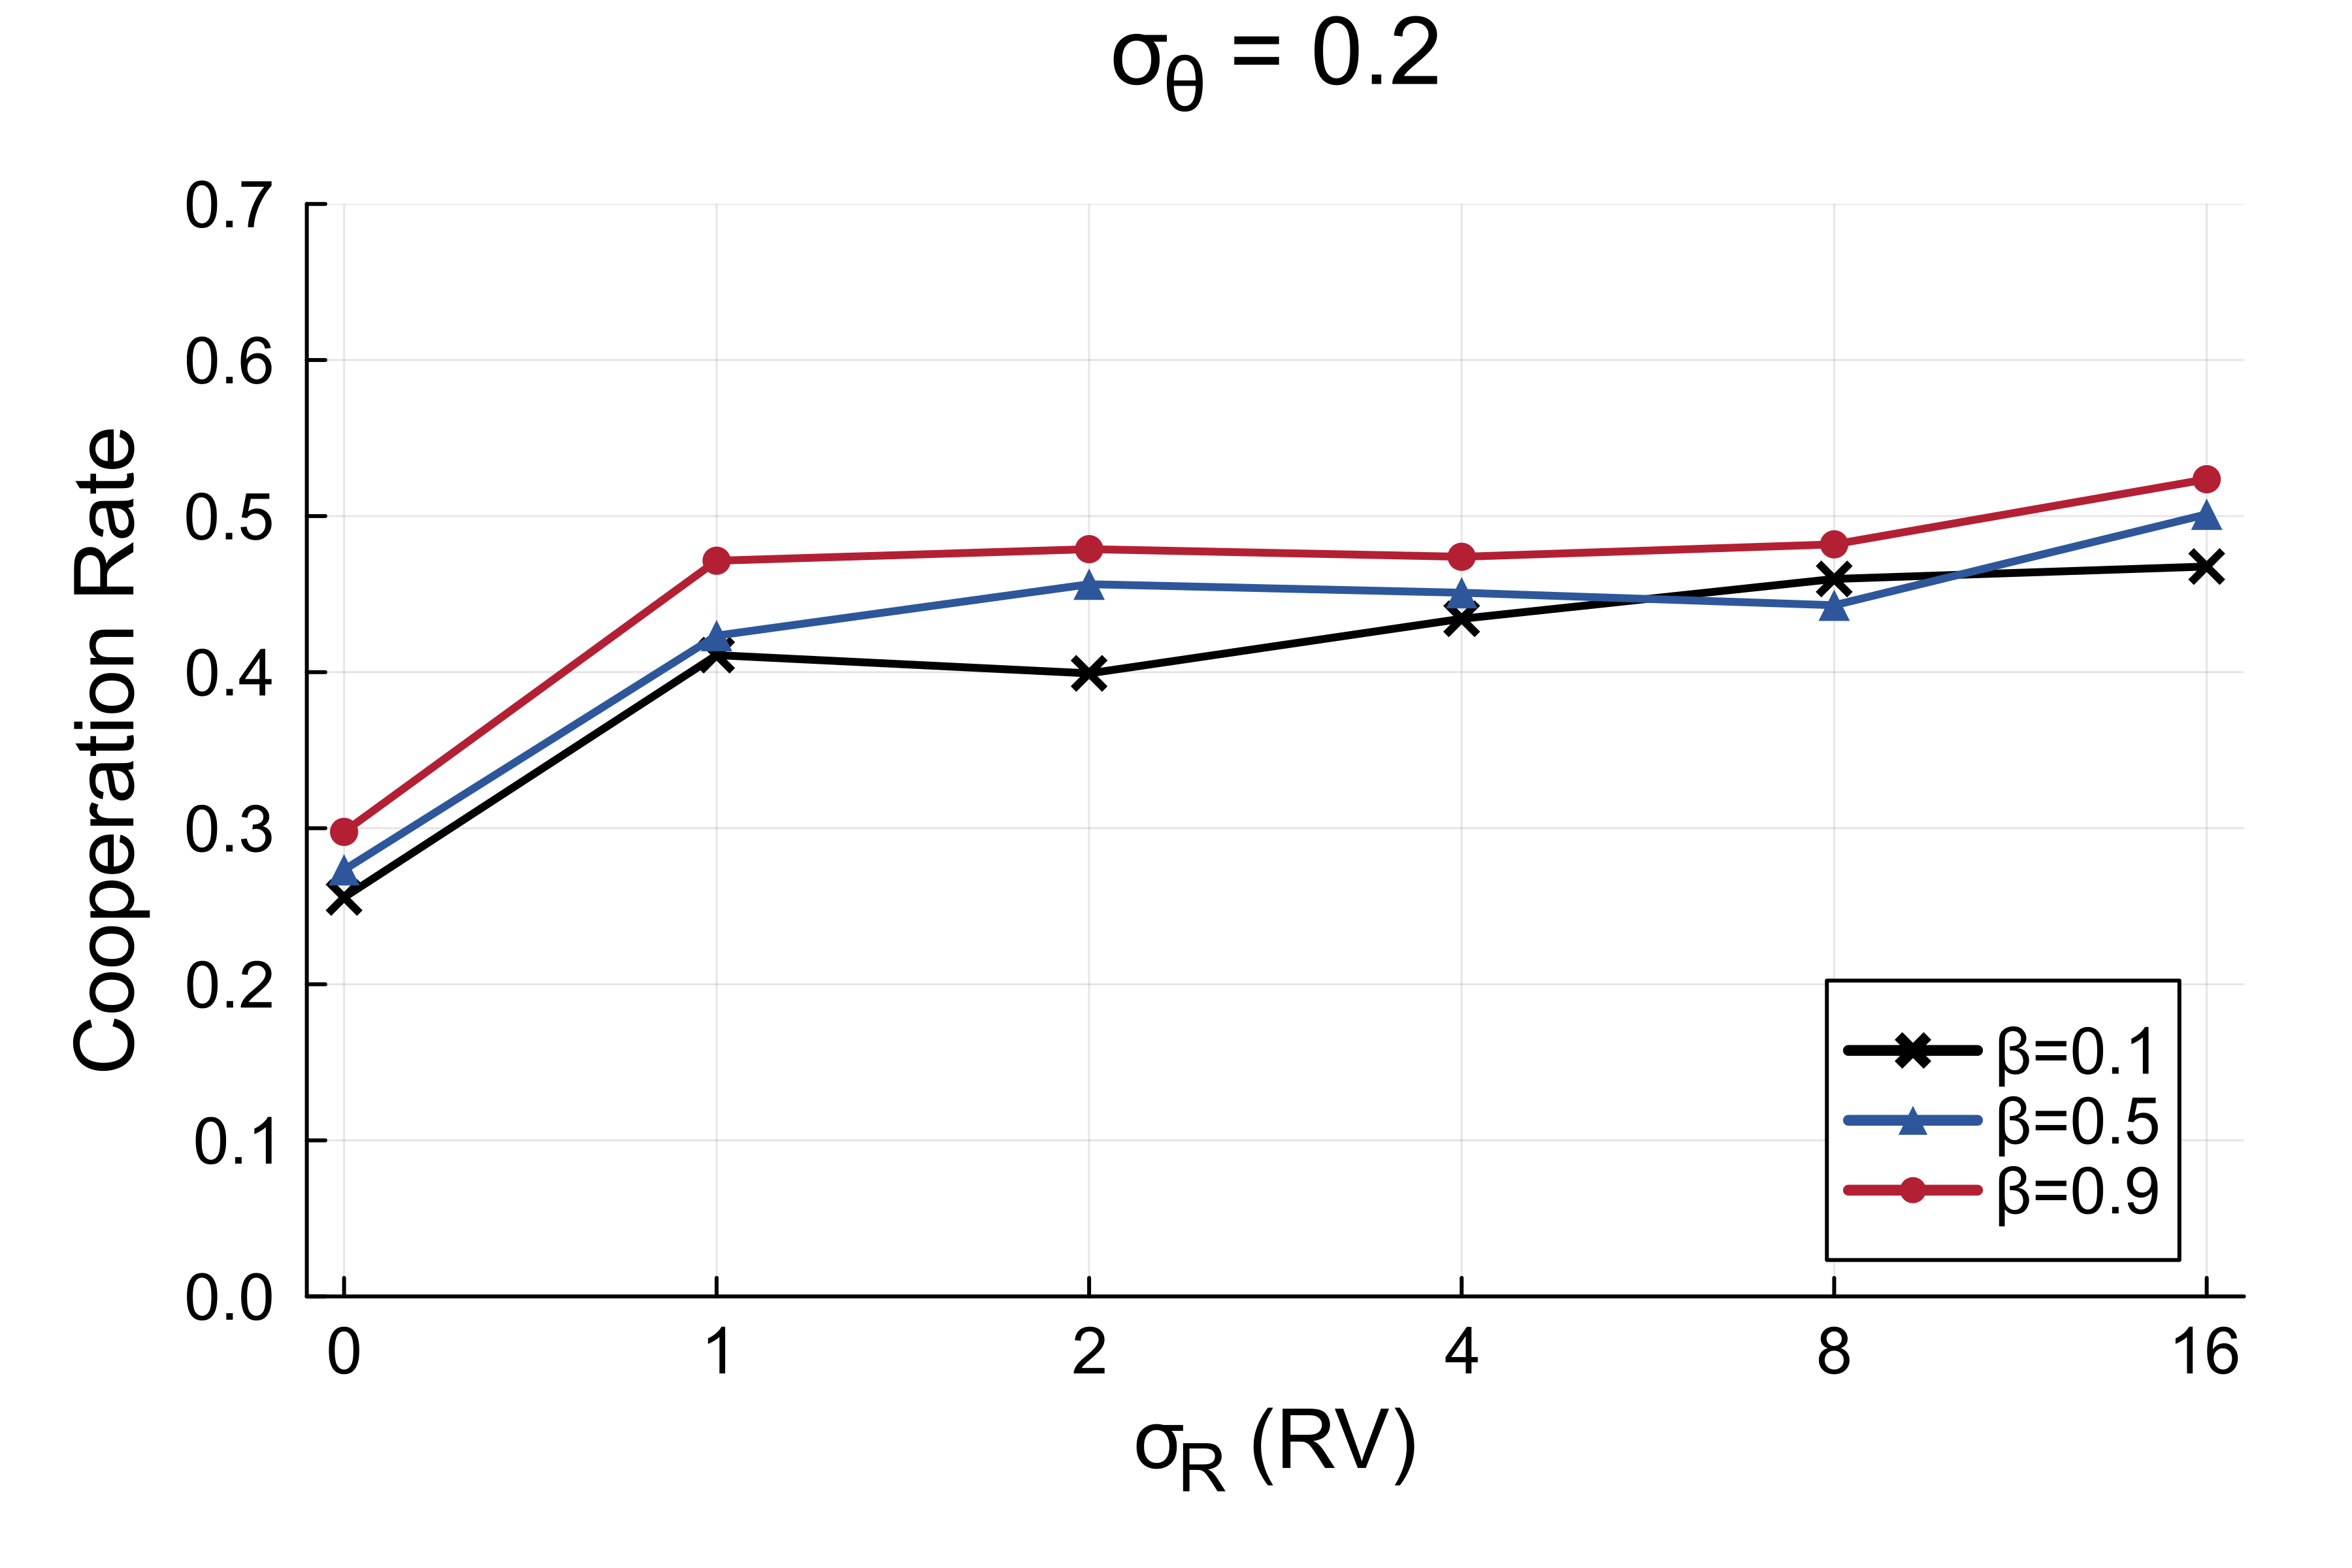

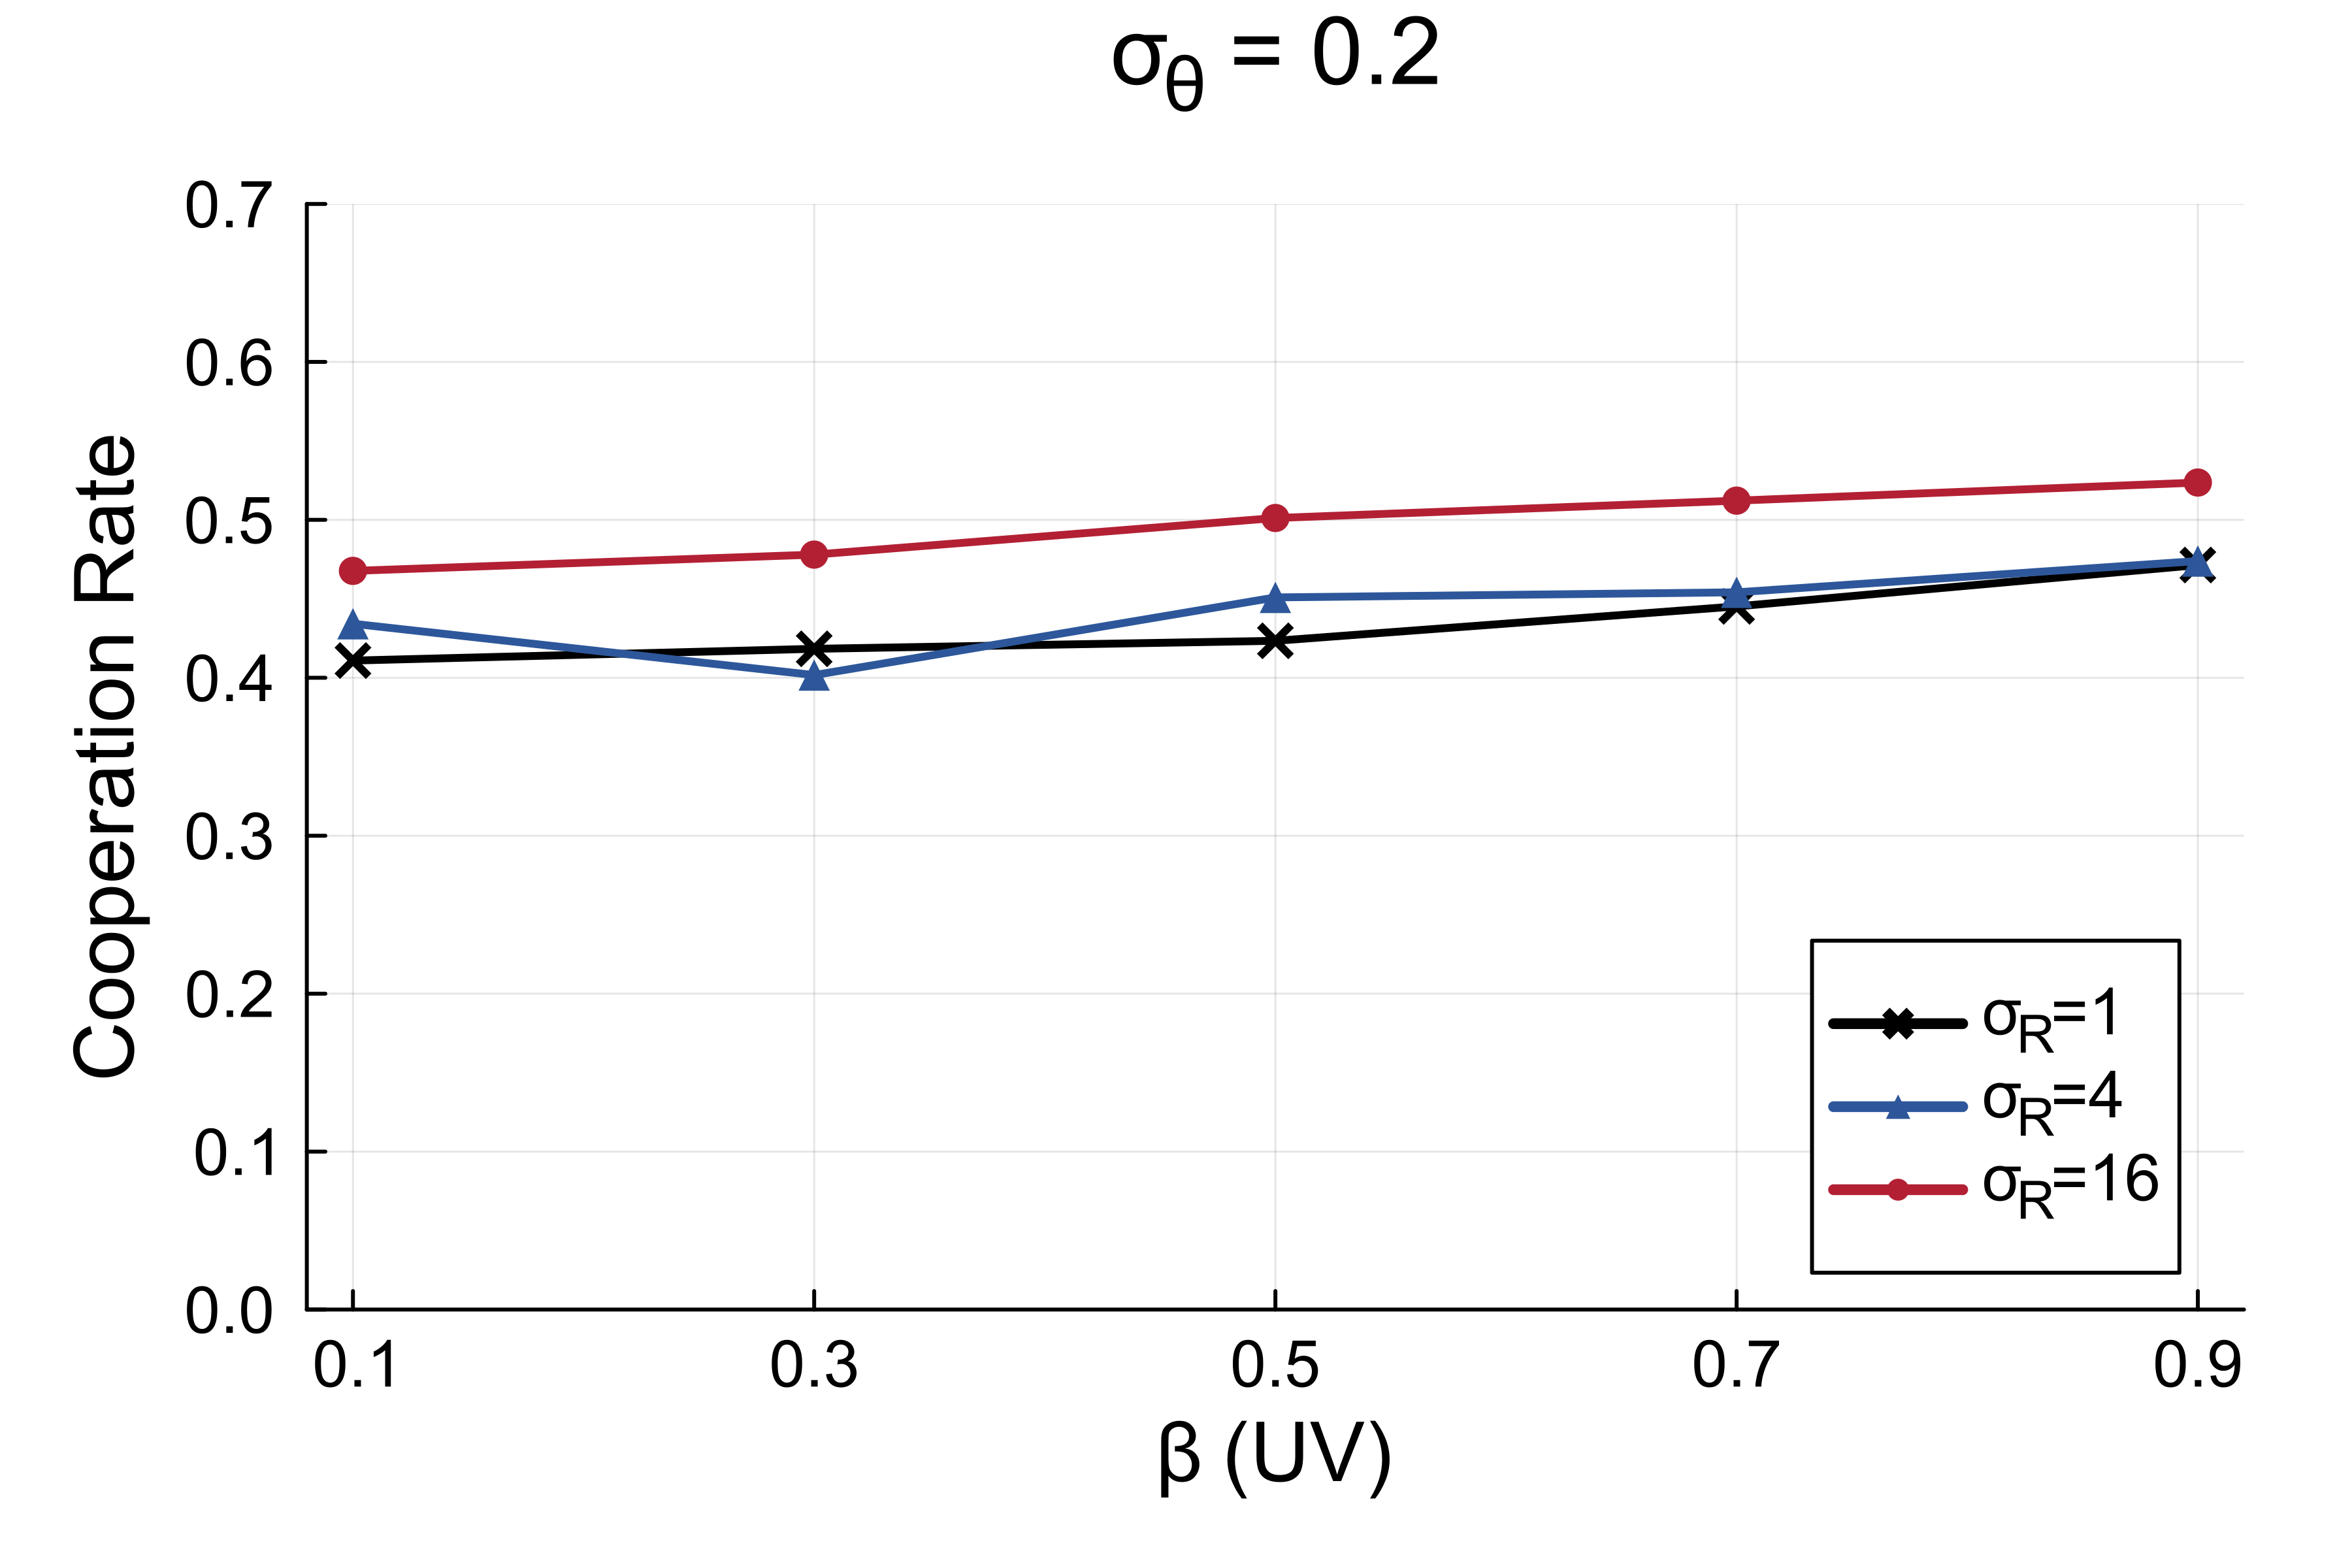

In [7]:
function plot_fig_combination(df::DataFrame, b::Float64)::Nothing
    b_vec = sort(unique(combination_var_df.b))
    σR_vec = sort(unique(combination_var_df.peak_node_variability))
    σθ_vec = sort(unique(combination_var_df.resource_limit_σ))
    β_vec = sort(unique(combination_var_df.resource_limit_β))

    for σθ in σθ_vec
        title = "\\sigma_{\\theta} = $(σθ)"
        ylabel = "Cooperation Rate"
        @show 
        p = plot(
            xticks=(1:length(σR_vec), σR_vec),
            xlim=(0.9, length(σR_vec)+0.1),
            # xscale=:log2,
            yticks=0:0.1:1.0,
            ylim=(0, 0.7),
            xlabel="\\sigma_{R} (RV)",
            ylabel=ylabel,
            title=title,
            legend=:bottomright,
        )
        for β in [0.1, 0.5, 0.9]
            _df = combination_var_df[
                combination_var_df.resource_limit_σ .== σθ .&&
                combination_var_df.resource_limit_β .== β .&&
                combination_var_df.b .== b, :]
            plot!(_df.cooperation_rate, label="β=$(β)", lc=line_color(β), mc=line_color(β), marker=line_marker(β))
        end
        display(p)
        savefig("img/fig4_Regional_$(σθ).png")

        p = plot(
            xticks=(1:length(β_vec), β_vec),
            xlim=(0.9, length(β_vec)+0.1),
            yticks=0:0.1:1.0,
            ylim=(0, 0.7),
            xlabel="\\beta (UV)",
            ylabel=ylabel,
            title=title,
            legend=:bottomright,
        )
        for σR in [1, 4, 16]
            _df = combination_var_df[
                combination_var_df.resource_limit_σ .== σθ .&&
                combination_var_df.peak_node_variability .== σR .&&
                combination_var_df.b .== b, :]
            plot!(_df.cooperation_rate, label="\\sigma_{R}=$(σR)", lc=line_color(σR), mc=line_color(σR), marker=line_marker(σR))
        end
        display(p)
        savefig("img/fig4_Universal_$(σθ).png")
    end

    return
end

plot_fig_combination(combination_var_df, 1.9)